# UMAP
UMAP, which stands for Uniform Manifold Approximation and Projection, is a dimensionality reduction technique used in machine learning and data analysis. It is particularly popular for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D, making it easier to explore and understand complex datasets. \
Key Features of UMAP:
* **Dimensionality Reduction:** UMAP reduces the number of dimensions in a dataset while preserving its structure as much as possible. This helps in visualizing and analyzing data that has many features.
* **Topological Approach:** UMAP is based on manifold learning and topological data analysis. It constructs a high-dimensional graph representing the data and then optimizes a low-dimensional graph to be as similar as possible to the high-dimensional one.
* **Preservation of Local and Global Structure:** UMAP aims to maintain both the local and global structure of the data, ensuring that points that are close in the high-dimensional space remain close in the lower-dimensional representation.
* **Scalability:** UMAP is designed to be scalable and can handle large datasets efficiently, making it suitable for modern big data applications.
* **Speed:** Compared to other dimensionality reduction techniques like t-SNE (t-Distributed Stochastic Neighbor Embedding), UMAP is generally faster and can produce embeddings more quickly, which is advantageous when working with large datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.preprocessing import StandardScaler
import umap

In [3]:
from platform import python_version
import sys
print('Python: ' + python_version()) # Python: 3.12.2
print('pandas: ' + pd.__version__) # pandas: 2.2.1
print ('matplotlib: ' + sys.modules["matplotlib"].__version__) # matplotlib: 3.8.3
print('seaborn: ' + sns.__version__) # seaborn: 0.13.2
print ('sklearn: ' + sys.modules["sklearn"].__version__) # sklearn: 1.4.1.post1
print('umap: ' + umap.__version__) # umap: 0.5.6

Python: 3.12.2
pandas: 2.2.1
matplotlib: 3.8.3
seaborn: 0.13.2
sklearn: 1.4.1.post1
umap: 0.5.6


# Load data

In [3]:
datacube_precip = np.load("./data/WaterPrecip_datacube_large.npy")
datacube_precip.shape

(9404, 180, 360)

In [4]:
date = np.load("./data/WaterPrecip_time_large.npy")
latitude = np.load("./data/WaterPrecip_latitude.npy")
longitude = np.load("./data/WaterPrecip_longitude.npy")

## Remove data slices that containins missing values (-99999)

In [5]:
date = date[datacube_precip.min(axis = (1,2)) >= 0]
len(date)

9232

In [6]:
datacube_precip = datacube_precip[datacube_precip.min(axis = (1,2)) >= 0,:,:]
## prepare data for the UMAP of the time dimension 
# datacube_precip = datacube_precip.reshape(-1,180*360)
## prepare data for the UMAP of the location (lat x lon) dimension
datacube_precip = datacube_precip.reshape(-1,180*360).T
datacube_precip.shape

(64800, 9232)

## Dimensionality reduction with UMAP

In [9]:
# instantializ the reducer
reducer = umap.UMAP(n_components=3)

In [10]:
# Convert each feature into z-scores (number of standard deviations from the mean) for comparability
datacube_precip_scaled = StandardScaler().fit_transform(datacube_precip)

In [11]:
# Delete the orginal data to save memory
del datacube_precip 

In [12]:
# Train thr reducer to fit the manifold.
embedding = reducer.fit_transform(datacube_precip_scaled)
embedding.shape

(64800, 3)

## Save dataframe for dash with the UMAP of the time dimension 

In [140]:
temp = pd.DataFrame({
    "Date":  date,
    "UMAP_1": embedding[:, 0],
    "UMAP_2": embedding[:, 1],
    "UMAP_3": embedding[:, 2]
})

In [142]:

## Sep Date
temp.loc[:,'Year'] = temp.loc[:,'Date'].map(lambda x: int(str(x)[:4]))
temp.loc[:,'Month'] = temp.loc[:,'Date'].map(lambda x: int(str(x)[4:6]))
temp.loc[:,'Day'] = temp.loc[:,'Date'].map(lambda x: int(str(x)[6:8]))

In [150]:
temp.loc[9231, "Precip"]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21452   , 0.21453863, 0.21527107, ..., 0.2529118 , 0.2511846 ,
        0.21508147],
       [1.2107724 , 1.2707181 , 1.2066858 , ..., 1.1666117 , 1.1609219 ,
        1.2189854 ],
       ...,
       [0.4045465 , 0.4240247 , 0.50440514, ..., 0.3410955 , 0.36459944,
        0.40694207],
       [0.908522  , 0.92515355, 0.91888875, ..., 0.9349263 , 0.93305576,
        0.9124936 ],
       [2.6244395 , 2.6243525 , 2.6232889 , ..., 2.613309  , 2.6154244 ,
        2.625588  ]], dtype=float32)

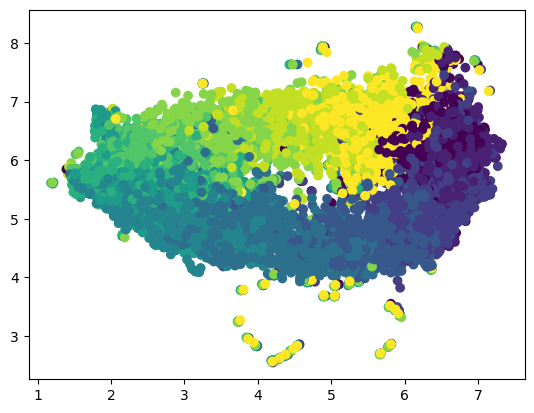

In [159]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=temp.loc[:,'Month'])
plt.show()

In [157]:
temp.to_pickle('./data/UMAP_time.pkl')  

## Save dataframe for dash with the UMAP of the location (lat x lon) dimension

In [67]:
temp = pd.DataFrame({
    "location":  [(x,y) for x in range(180) for y in range(360)],
    "UMAP_1": embedding[:, 0],
    "UMAP_2": embedding[:, 1],
    "UMAP_3": embedding[:, 2],
    "Mean": datacube_precip.mean(axis = 1),
    "Min": datacube_precip.min(axis = 1),
    "Max": datacube_precip.max(axis = 1),
    "Median": np.apply_along_axis(statistics.median, 1, datacube_precip)
})


In [11]:
## Sep location
temp.loc[:,'lat'] = temp.loc[:,'location'].map(lambda x: x[0])
temp.loc[:,'lon'] = temp.loc[:,'location'].map(lambda x: x[1])

In [12]:
temp

,location,UMAP_1,UMAP_2,UMAP_3,Precip,Mean,Min,Max,Median,lat,lon
0,"(0, 0)",13.538248,-1.049904,4.584060,"[0.41700584, 0.3138285, 0.0, 0.43401715, 1.231...",0.333623,0.0,10.992901,0.000000,0,0
1,"(0, 1)",13.562364,-1.028552,4.591996,"[0.41700584, 0.3138285, 0.0, 0.48881403, 1.321...",0.335442,0.0,10.999716,0.000000,0,1
2,"(0, 2)",13.546254,-1.043179,4.588313,"[0.41700584, 0.29605582, 0.0, 0.487921, 1.3210...",0.334642,0.0,11.028076,0.000000,0,2
3,"(0, 3)",13.577848,-1.015493,4.599356,"[0.4241956, 0.2902508, 0.0, 0.487921, 1.321054...",0.333477,0.0,10.802782,0.000000,0,3
4,"(0, 4)",13.645081,-0.955326,4.628580,"[0.43163761, 0.2902508, 0.0, 0.43310758, 1.231...",0.335419,0.0,10.642470,0.000000,0,4
...,...,...,...,...,...,...,...,...,...,...,...
64795,"(179, 355)",1.358901,8.767251,3.516376,"[0.0731147, 0.026505474, 0.45008138, 0.1477538...",0.502793,0.0,11.563543,0.011987,179,355
64796,"(179, 356)",1.296949,8.720201,3.491915,"[0.0, 0.026505474, 0.44293723, 0.15006253, 0.0...",0.500156,0.0,11.511600,0.008393,179,356
64797,"(179, 357)",1.296755,8.719646,3.490009,"[0.07082987, 0.026505474, 0.43601632, 0.147753...",0.500433,0.0,11.578689,0.008419,179,357
64798,"(179, 358)",1.295427,8.718801,3.490315,"[0.07082987, 0.029191552, 0.42930838, 0.250481...",0.500902,0.0,11.550543,0.008949,179,358


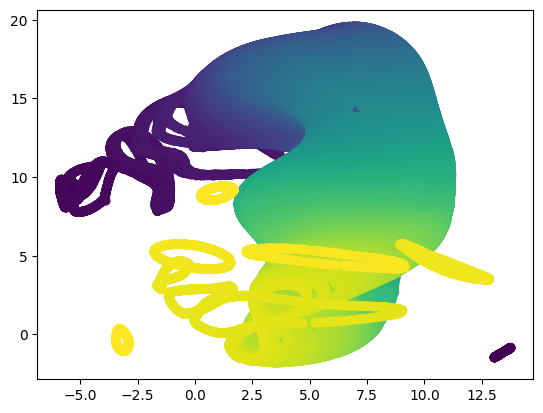

In [20]:
plt.scatter(
    temp.loc[:,'UMAP_1'],
    temp.loc[:,'UMAP_2'],
    c=temp.loc[:,'lat']
)
plt.show()

In [13]:
temp.to_pickle('./data/UMAP_location.pkl')  